In [16]:
# !pip install "numpy<2.0" "shap<0.47"
# !pip install "numexpr>=2.10.2"
import shap
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_val_score, 
    GridSearchCV,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_predict)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    make_scorer,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef,
    precision_recall_curve,
    roc_curve, 
    auc,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import os

In [2]:
train_df = pd.read_csv('combined_train_with_labels.csv.gz')
train_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2120.0,-635333.796311,...,65.0,85.0,0.142357,3,1.198436,0.059642,0.519805,1.000000,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2004.0,-289756.893085,...,60.0,87.0,0.151160,3,1.381123,0.061975,0.531775,1.000000,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2125.0,-379843.029134,...,67.0,95.0,0.142606,3,1.361857,0.050813,0.343676,1.000000,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2098.0,-252673.626844,...,90.0,116.0,0.133192,2,1.165654,0.062954,0.483144,1.000000,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2037.0,-317761.453582,...,61.0,94.0,0.145504,7,1.390918,0.055013,0.377738,1.000000,53.0,0.035971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-240759.341995,...,55.0,90.0,0.151747,6,1.008092,0.062825,0.573645,33.442724,69.0,0.035228
1039996,1039996_train_15,380.170340,True,True,True,True,949,3404.0,2045.0,-417622.302428,...,57.0,79.0,0.150305,3,1.245492,0.062706,0.564955,58.862967,71.0,0.034669
1039997,1039997_train_15,370.109563,False,True,True,True,947,3409.0,2063.0,-407730.168602,...,77.0,102.0,0.142950,2,1.149456,0.062153,0.473789,143.746154,79.0,0.034553
1039998,1039998_train_15,98.258524,True,True,True,False,921,3400.0,2001.0,-116570.568893,...,71.0,92.0,0.153135,5,1.192639,0.065264,0.572606,1.000000,42.0,0.039377


In [3]:
test_df = pd.read_csv('combined_test_with_labels.csv.gz')
test_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,2395098_test_0,1167.174731,True,True,True,True,967,3407.0,2036.0,-1.300536e+06,...,55.0,76.0,0.148591,1,1.282821,0.062497,0.553581,2.257453e+02,69.0,0.034373
1,2395099_test_0,870.765543,False,True,True,False,960,3405.0,2019.0,-9.729822e+05,...,70.0,90.0,0.147334,1,1.203640,0.063886,0.573090,2.120524e+12,88.0,0.034307
2,2395100_test_0,582.980526,False,True,True,True,960,3412.0,2107.0,-6.390870e+05,...,76.0,100.0,0.139090,2,1.189320,0.057715,0.443685,1.784824e+02,84.0,0.034885
3,2395101_test_0,238.918902,True,True,True,True,930,3408.0,2053.0,-2.760460e+05,...,88.0,110.0,0.138597,2,1.226275,0.067184,0.583046,1.000000e+00,53.0,0.035474
4,2395102_test_0,214.491195,False,True,True,True,924,3406.0,1939.0,-7.611188e+04,...,83.0,135.0,0.149185,13,1.203153,0.055602,0.403248,1.000000e+00,46.0,0.051582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389995,2785093_test_5,238.472881,False,True,True,False,940,3406.0,2081.0,-2.667054e+05,...,69.0,111.0,0.144375,2,1.198436,0.062338,0.518905,1.000000e+00,73.0,0.034997
389996,2785094_test_5,452.840234,True,True,True,True,952,3406.0,2058.0,-5.194853e+05,...,59.0,83.0,0.148058,3,2.268535,0.064586,0.590262,5.597816e+01,54.0,0.035930
389997,2785095_test_5,344.740556,True,True,True,True,948,3406.0,2036.0,-3.684673e+05,...,80.0,125.0,0.140774,3,1.217066,0.062375,0.536752,1.000000e+00,82.0,0.034713
389998,2785096_test_5,163.807547,True,True,True,True,925,3406.0,2067.0,-1.903450e+05,...,94.0,116.0,0.140754,2,0.975055,0.066704,0.577498,1.000000e+00,41.0,0.036159


In [6]:
classification_label_cols = [
    "psd_label_lq",
    "psd_label_high_avse",
    "psd_label_low_avse",
    "psd_label_dcr"
]

non_label_cols = ["id", "energy_label"]

feature_cols = [col for col in train_df.columns if col not in classification_label_cols+non_label_cols]
print("Number of feataures:",len(feature_cols))
feature_cols

Number of feataures: 27


['tp0',
 'ED',
 'HWP',
 'LQ80',
 'PPR',
 'SCA',
 'ND80',
 'current_skewness',
 'tail_slope_no_pz',
 'spectral_centroid_power',
 'current_kurtosis',
 'tail_slope',
 'total_power',
 'time_to_main_peak',
 'time_to_peak',
 'current_width',
 'tdrift10',
 'tdrift50',
 'tdrift99',
 'tfr',
 'peak_count',
 'gbn',
 'bpr',
 'AvsE',
 'GradAreaRatio',
 'GradWidthMain',
 'HFER']

In [7]:
# Filter rows where ALL of these columns are True
# .all(axis=1) checks if every column in the list is True for that row
matching_rows = train_df[train_df[classification_label_cols].all(axis=1)]
matching_rows

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
5,5_train_0,202.118818,True,True,True,True,938,3401.0,2016.0,-2.238298e+05,...,62.0,86.0,0.148161,2,1.333229,0.066141,0.588104,2.991743e+01,39.0,0.048042
6,6_train_0,855.765685,True,True,True,True,953,3413.0,2110.0,-9.533368e+05,...,88.0,106.0,0.136972,1,1.463301,0.061205,0.528196,1.570316e+02,93.0,0.034815
8,8_train_0,1212.688940,True,True,True,True,961,3412.0,2089.0,-1.336303e+06,...,82.0,105.0,0.140185,1,1.217066,0.065910,0.591604,1.603469e+02,92.0,0.034293
11,11_train_0,2334.785962,True,True,True,True,961,3412.0,2061.0,-2.494320e+06,...,92.0,117.0,0.139700,1,1.488288,0.062823,0.566847,5.637905e+12,109.0,0.034266
14,14_train_0,2130.987393,True,True,True,True,980,3401.0,2057.0,-2.373392e+06,...,21.0,43.0,0.157380,1,2.648069,0.072427,0.639669,5.235714e+12,48.0,0.033637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039985,1039985_train_15,238.270546,True,True,True,True,966,3401.0,2024.0,-2.676853e+05,...,26.0,77.0,0.164503,2,1.653406,0.070927,0.611792,3.050746e+01,42.0,0.034336
1039986,1039986_train_15,230.961021,True,True,True,True,929,3408.0,2032.0,-2.581743e+05,...,94.0,116.0,0.138498,1,1.165428,0.069788,0.606824,8.871756e+01,64.0,0.034692
1039990,1039990_train_15,299.894902,True,True,True,True,932,3407.0,2021.0,-3.529948e+05,...,84.0,119.0,0.138221,4,1.135231,0.066935,0.584033,1.000000e+00,52.0,0.034463
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-2.407593e+05,...,55.0,90.0,0.151747,6,1.008092,0.062825,0.573645,3.344272e+01,69.0,0.035228


# MODEL TRAINING - psd_label_high_avse

In [8]:
# DATA PREP
X_train = train_df[feature_cols]
y_train = train_df["psd_label_high_avse"]

X_test = test_df[feature_cols]
y_test = test_df["psd_label_high_avse"]

### Test Dataset

In [7]:
pd.concat([y_test.value_counts(), 
           y_test.value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,386840,0.991897
False,3160,0.008103


In [19]:
X_test.isna().sum().sort_values(ascending=False)

tp0                        0
time_to_peak               0
GradWidthMain              0
GradAreaRatio              0
AvsE                       0
bpr                        0
gbn                        0
peak_count                 0
tfr                        0
tdrift99                   0
tdrift50                   0
tdrift10                   0
current_width              0
time_to_main_peak          0
ED                         0
total_power                0
tail_slope                 0
current_kurtosis           0
spectral_centroid_power    0
tail_slope_no_pz           0
current_skewness           0
ND80                       0
SCA                        0
PPR                        0
LQ80                       0
HWP                        0
HFER                       0
dtype: int64

### Train Dataset

In [9]:
pd.concat([y_train.value_counts(), 
           y_train.value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,1031559,0.991884
False,8441,0.008116


In [20]:
X_train.isna().sum().sort_values(ascending=False)

tdrift99                   5
tdrift50                   5
tdrift10                   5
tp0                        0
time_to_peak               0
GradWidthMain              0
GradAreaRatio              0
AvsE                       0
bpr                        0
gbn                        0
peak_count                 0
tfr                        0
current_width              0
time_to_main_peak          0
ED                         0
total_power                0
tail_slope                 0
current_kurtosis           0
spectral_centroid_power    0
tail_slope_no_pz           0
current_skewness           0
ND80                       0
SCA                        0
PPR                        0
LQ80                       0
HWP                        0
HFER                       0
dtype: int64

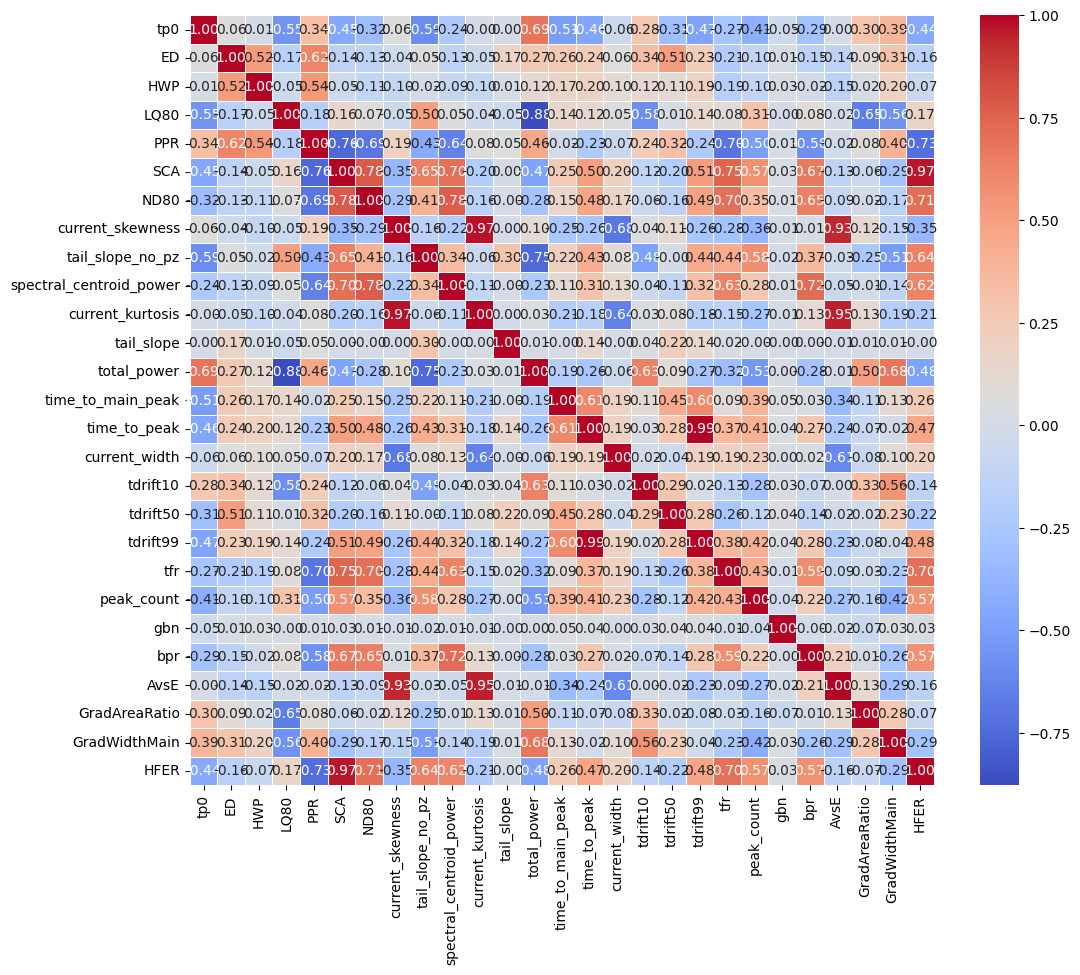

In [17]:
correlation_matrix = pd.DataFrame(X_train).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm',fmt=".2f", linewidths=.5)

plt.savefig('/home/nbatjargal/DSC180A_FA25_A00/correlation_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

Plotting 27 features in 3 batches...


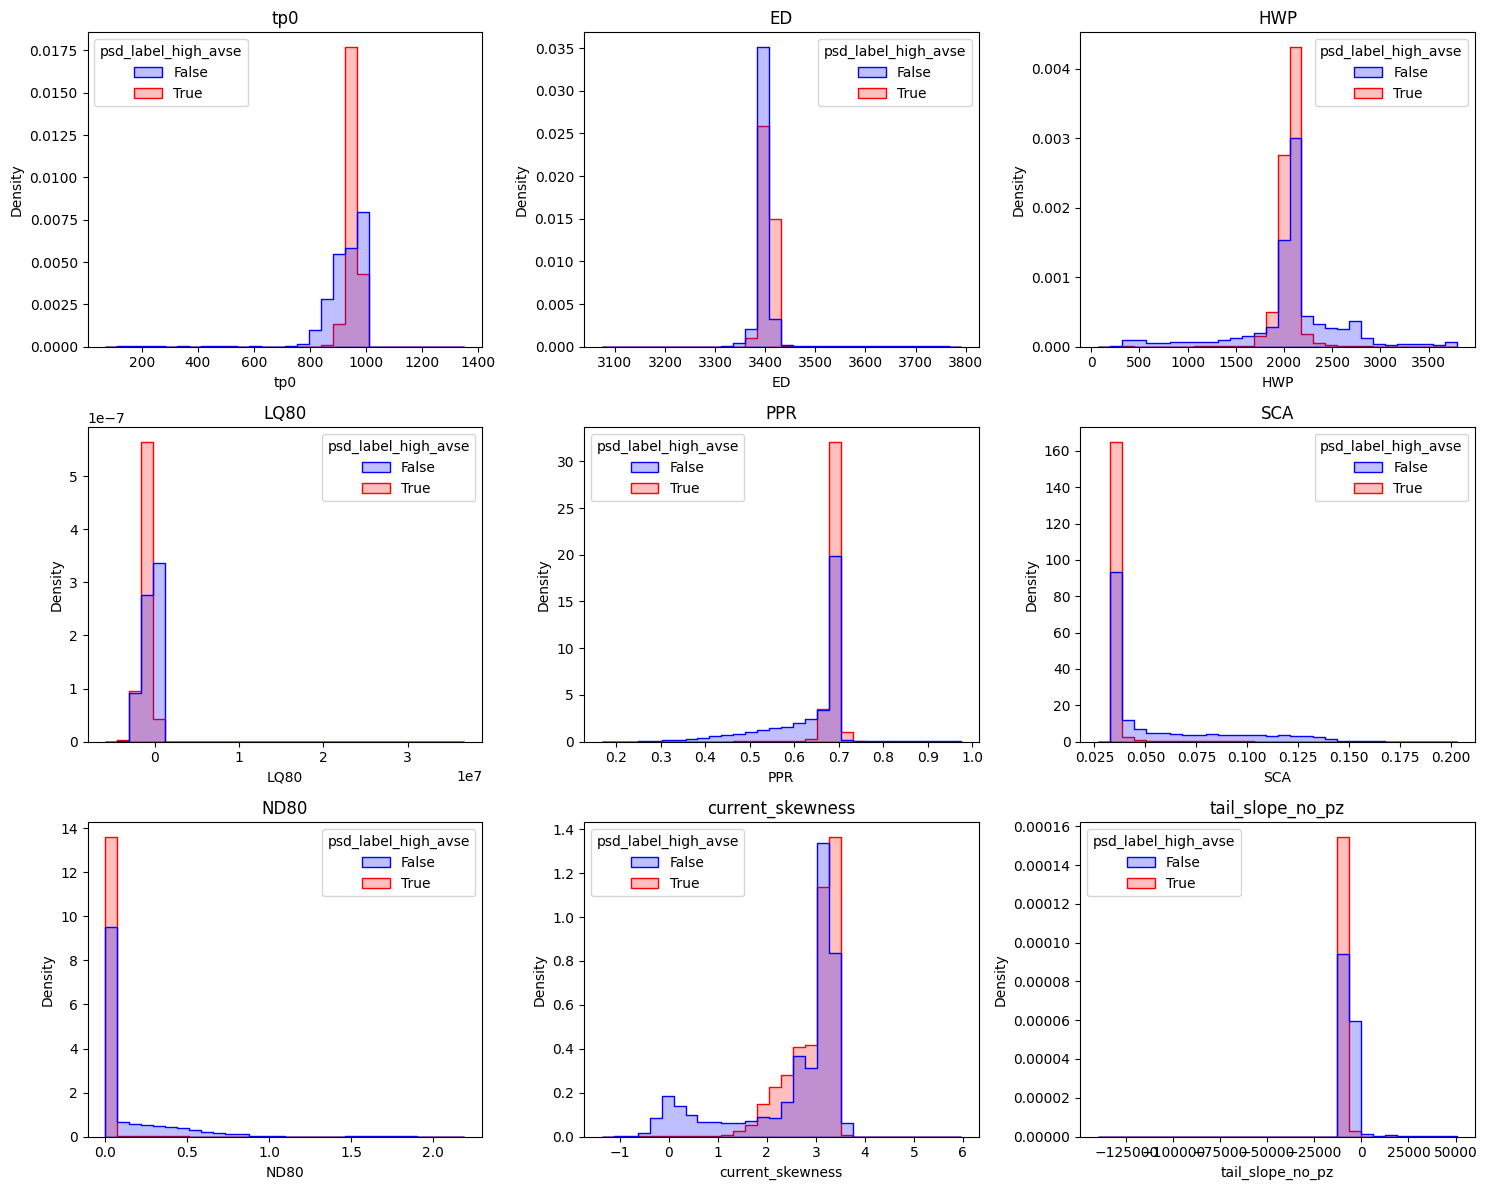

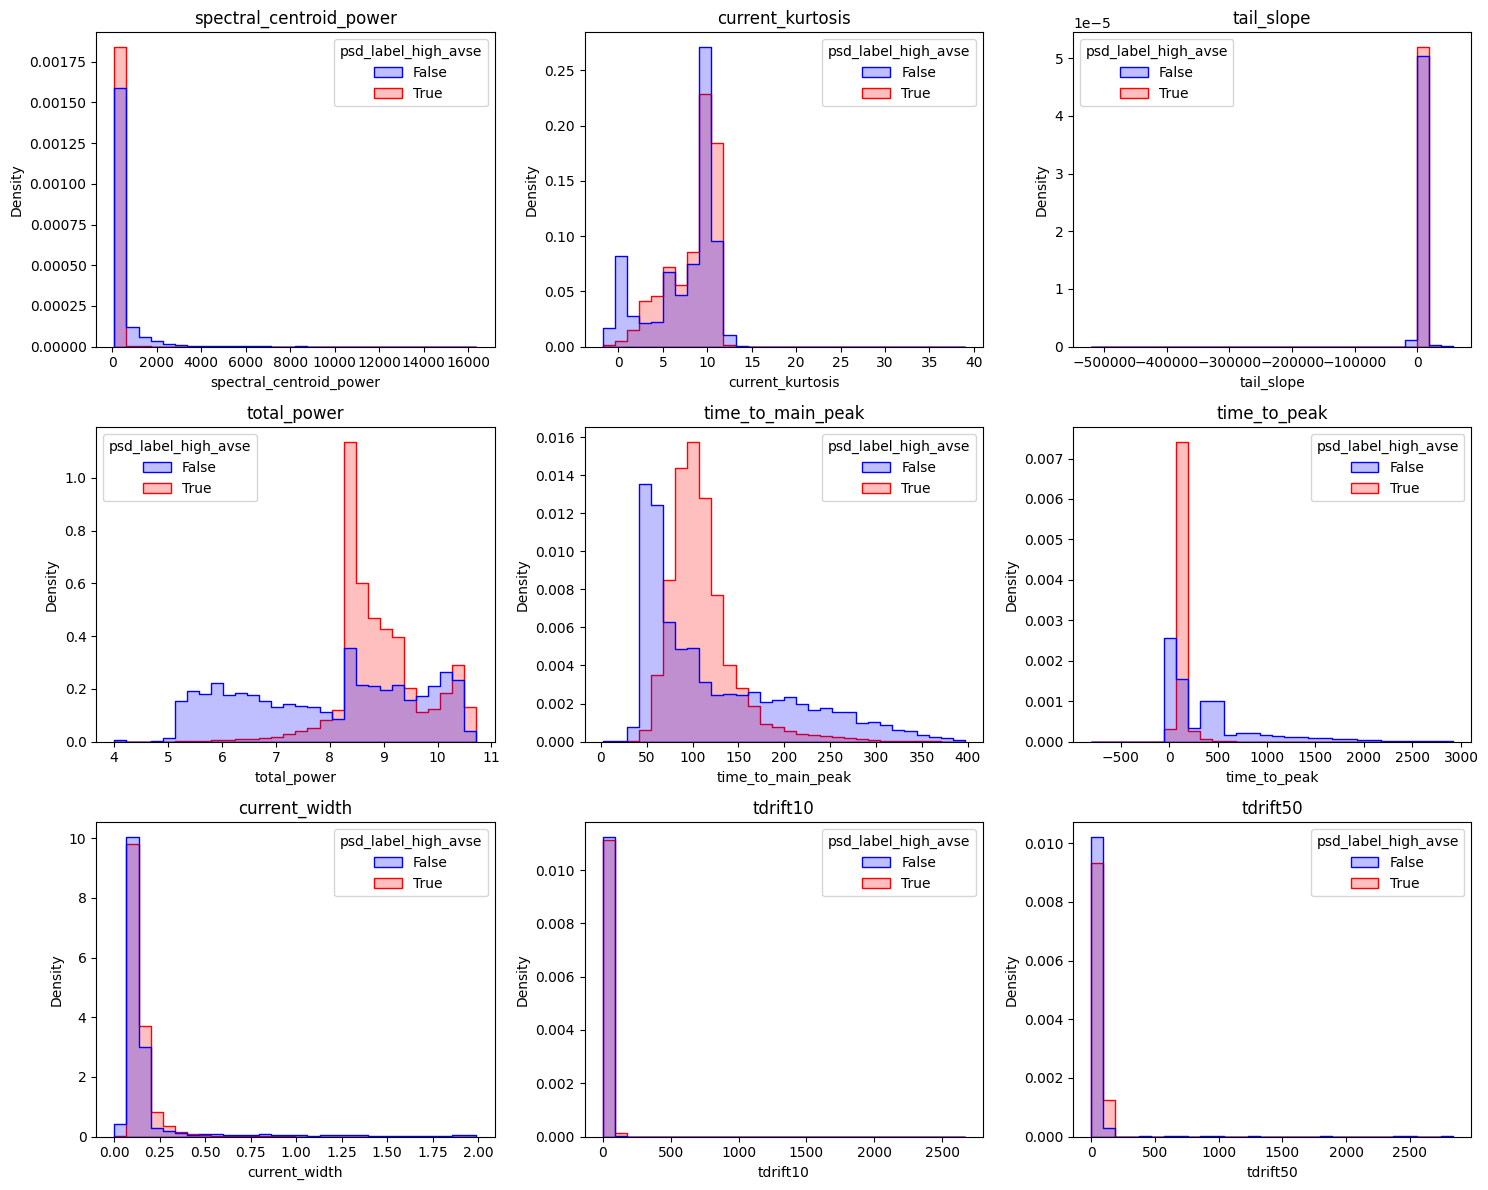

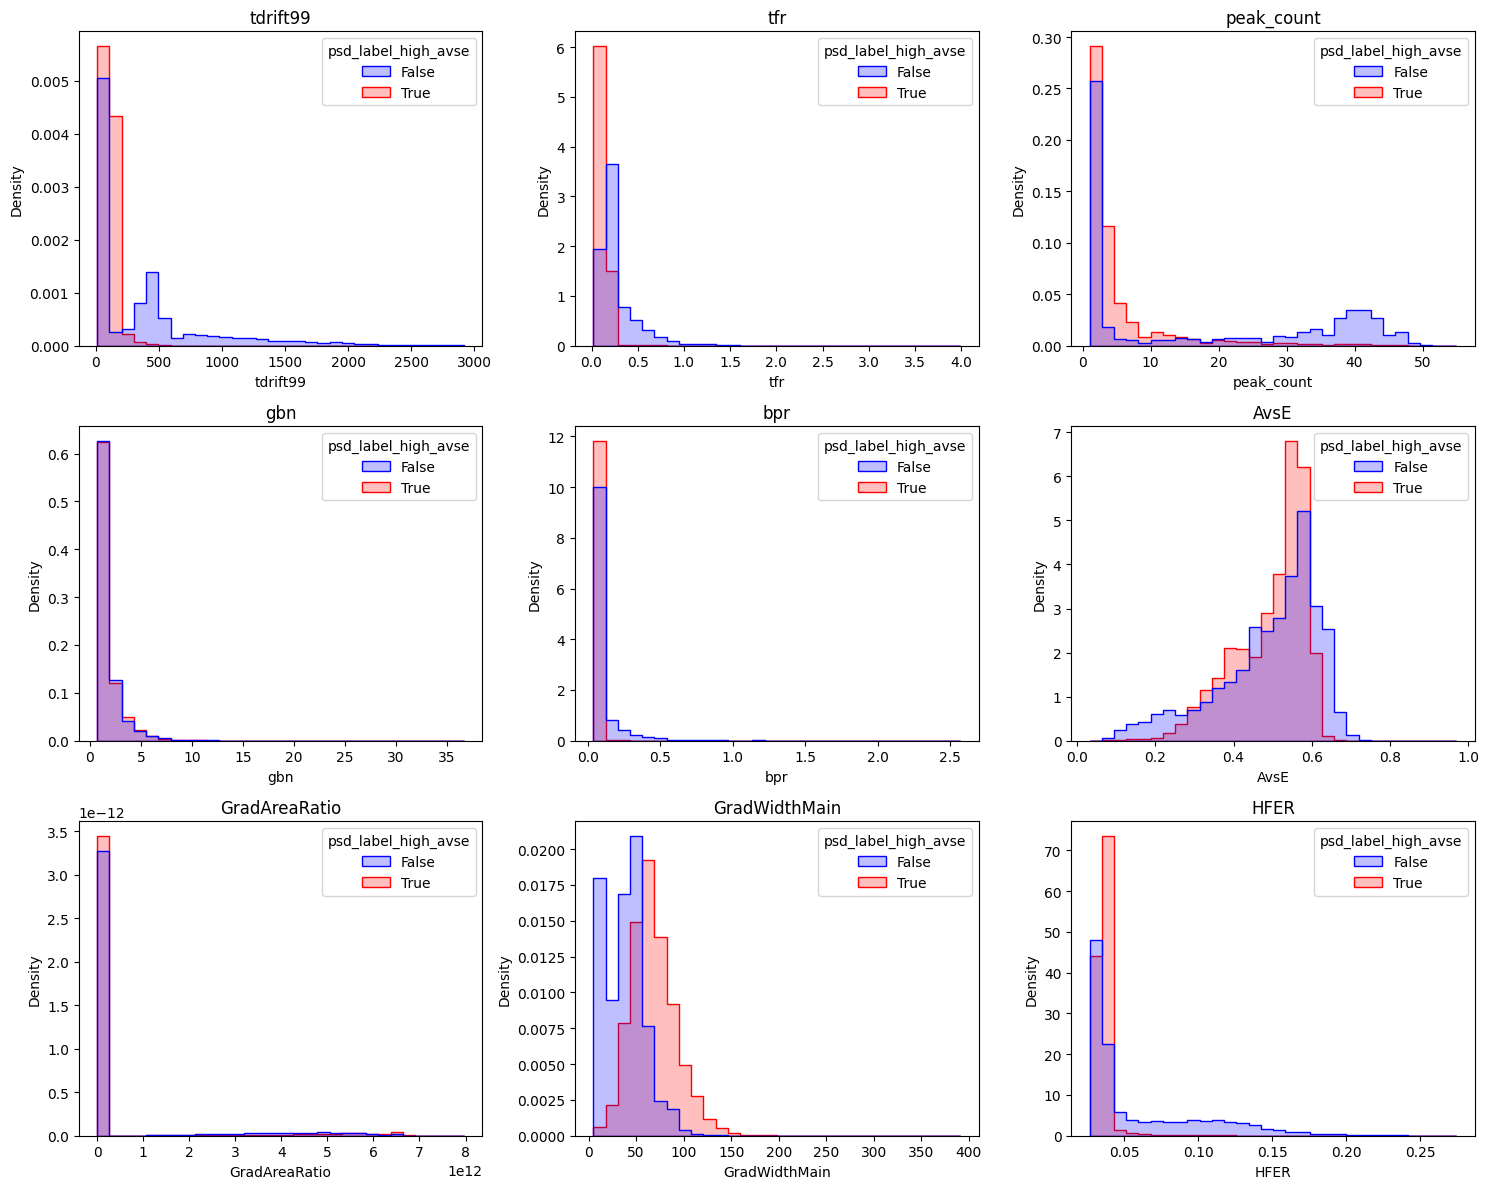

In [18]:
features_per_batch = 9  # Plot 9 features at a time
total_features = len(feature_cols)
num_batches = math.ceil(total_features / features_per_batch)

print(f"Plotting {total_features} features in {num_batches} batches...")

for b in range(num_batches):
    start = b * features_per_batch
    end = min((b + 1) * features_per_batch, total_features)
    batch_features = feature_cols[start:end]
    
    # Create a smaller figure for just this batch
    n_cols = 3
    n_rows = math.ceil(len(batch_features) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
    
    for i, feature in enumerate(batch_features):
        sns.histplot(
            data=train_df, 
            x=feature, 
            hue='psd_label_high_avse', 
            element="step", 
            stat="density", 
            common_norm=False, 
            ax=axes[i],
            palette=['blue', 'red'],
            bins=30  # LIMIT BINS to prevent infinite binning on outliers
        )
        axes[i].set_title(feature)
        
    # Hide empty axes in the last batch
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()  # Renders and CLEARS memory

### DEFINE CUSTOM SCORERS (For Tuning)

In [9]:
# We wrap these in make_scorer so RandomizedSearchCV can track counts
def tn_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def fp_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def fn_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def tp_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

scoring_metrics = {
    'MCC': make_scorer(matthews_corrcoef),
    'AUC_PR': make_scorer(average_precision_score, response_method="predict_proba"),
    'AUC_ROC': make_scorer(roc_auc_score, response_method="predict_proba"),
    'Class0_F1': make_scorer(f1_score, pos_label=0), 
    'Class1_F1': make_scorer(f1_score, pos_label=1),
    'TN': make_scorer(tn_score),
    'FP': make_scorer(fp_score),
    'FN': make_scorer(fn_score),
    'TP': make_scorer(tp_score)
}

# columns we want to keep
cols_to_show = [
    'params',
    'mean_test_MCC', 
    'mean_test_AUC_PR', 
    'mean_test_AUC_ROC',
    'mean_test_Class0_F1',
    'mean_test_Class1_F1',
    'mean_test_TN', 'mean_test_FP', # Class 0 Performance
    'mean_test_TP', 'mean_test_FN', # Class 1 Performance
]

In [12]:
def tune_thresholds(model, X_train, y_train, cv=5, thresholds=None):
    """
    Finds the optimal probability threshold using Cross-Validation on the Training set.
    This prevents data leakage by NOT using the Test set for tuning.
    
    Args:
        model: The classifier (estimator) to evaluate.
        X_train: Training features.
        y_train: Training labels.
        cv: Number of cross-validation folds (default 5).
        thresholds: List of thresholds to test. If None, uses default range.
        
    Returns:
        pd.DataFrame: Sorted results by MCC.
    """
    
    print(f"Generating Cross-Validated Probabilities (CV={cv})...")
    
    # 1. Generate "Clean" Probabilities via Cross-Validation
    # This predicts for each fold as if it were unseen data
    if hasattr(model, "predict_proba"):
        y_probas_cv = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    else:
        raise ValueError("Model must support predict_proba")

    # 2. Define Thresholds
    if thresholds is None:
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

    # 3. Calculate Constant Metrics (CV-based)
    cv_auc_pr = average_precision_score(y_train, y_probas_cv)
    cv_auc_roc = roc_auc_score(y_train, y_probas_cv)

    results = []

    # 4. Loop through thresholds
    for thresh in thresholds:
        # Apply Threshold
        y_pred = (y_probas_cv >= thresh).astype(int)
        
        # Calculate Confusion Matrix
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
        # Calculate Scores
        results.append({
            'Threshold': thresh,
            'MCC': matthews_corrcoef(y_train, y_pred),
            'Precision': precision_score(y_train, y_pred, zero_division=0),
            'Recall': recall_score(y_train, y_pred, zero_division=0),
            'True_F1': f1_score(y_train, y_pred, pos_label=1),
            'False_F1': f1_score(y_train, y_pred, pos_label=0),
            'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp,
            'CV_AUC_PR': cv_auc_pr,
            'CV_AUC_ROC': cv_auc_roc
        })

    # 5. Return Sorted Table
    df_results = pd.DataFrame(results)
    return df_results.sort_values(by='MCC', ascending=False)

In [8]:
def evaluate_model_with_threshold(model, X_test, y_test, threshold, model_name):
    """
    Evaluates a model using a specific decision threshold and plots the confusion matrix.
    
    Args:
        model: Trained classifier (must have predict_proba).
        X_test: Test features.
        y_test: True test labels.
        threshold (float): Decision threshold (e.g., 0.5 or optimized value).
        model_name (str): Name for printing and plot titles (e.g., "XGBoost").
    """
    print(f"\n{'='*40}")
    print(f" EVALUATION: {model_name} (Threshold = {threshold})")
    print(f"{'='*40}")

    # 1. Get Probabilities (Probability of Class 1 / SSE)
    y_probs = model.predict_proba(X_test)[:, 1]

    # 2. Apply the Custom Threshold
    y_pred = (y_probs >= threshold).astype(int)

    # 3. Print Classification Report
    print(classification_report(y_test, y_pred, digits=4))

    # 4. AUC-ROC (Threshold Independent)
    auc_roc = roc_auc_score(y_test, y_probs)
    print(f"AUC-ROC Score: {auc_roc}")

    # 5. AUC-PR (Threshold Independent)
    auc_pr = average_precision_score(y_test, y_probs)
    print(f"AUC-PR Score:  {auc_pr}")

    # 6. MCC (Threshold Dependent)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"MCC Score:     {mcc}")

    # 7. Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])
    
    # Use different colors for different models (Blue default)
    cmap = 'Blues'
    
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap=cmap, ax=ax)
    plt.title(f"{model_name} Confusion Matrix\n(Threshold = {threshold})")
    plt.show()

## Baseline Logistic Regression

In [10]:
# Baseline performance
pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

In [11]:
# Train
pipe_baseline.fit(X_train, y_train)

# Predict 
y_pred_baseline = pipe_baseline.predict(X_test)
# get predicted probabilities of the positive class (index 1)
y_proba_baseline = pipe_baseline.predict_proba(X_test)[:, 1]

In [13]:
# Calculate Confusion Matrix components manually
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_baseline).ravel()

# Create a dictionary of results (mimicking your GridSearchCV output)
baseline_results = {
    'model': 'Baseline (LogReg)',
    'MCC': matthews_corrcoef(y_test, y_pred_baseline),
    'AUC_PR': average_precision_score(y_test, y_proba_baseline),
    'AUC_ROC': roc_auc_score(y_test, y_proba_baseline),
    'Class0_F1': f1_score(y_test, y_pred_baseline, pos_label=0),
    'Class1_F1': f1_score(y_test, y_pred_baseline, pos_label=1),
    'TN': tn,
    'FP': fp,
    'FN': fn,
    'TP': tp
}

# Display as a nice DataFrame
df_baseline = pd.DataFrame([baseline_results])
df_baseline.T

,0
model,Baseline (LogReg)
MCC,0.25763
AUC_PR,0.999538
AUC_ROC,0.958572
Class0_F1,0.154212
Class1_F1,0.959365
TN,2757
FP,403
FN,29839
TP,357001


              precision    recall  f1-score   support

       False       0.08      0.87      0.15      3160
        True       1.00      0.92      0.96    386840

    accuracy                           0.92    390000
   macro avg       0.54      0.90      0.56    390000
weighted avg       0.99      0.92      0.95    390000



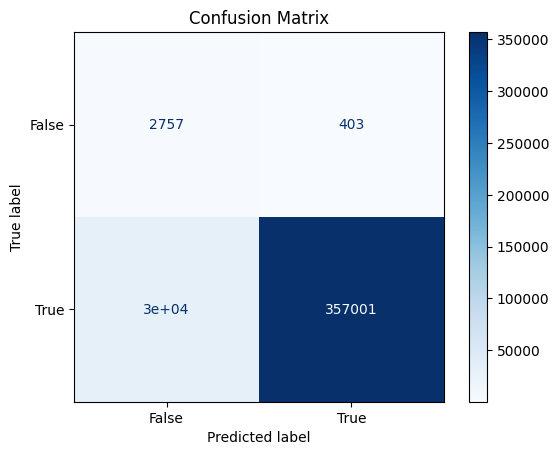

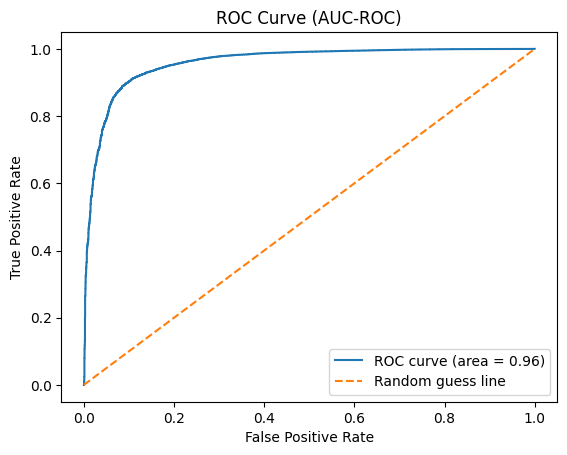

In [15]:
# ---- choose where to save ----
save_dir = "plots"  # or any path you want
os.makedirs(save_dir, exist_ok=True)

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')  # values_format optional
plt.title("Confusion Matrix")
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "confusion_matrix_baseline.png"),
            dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# -------------------- ROC Curve --------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba_baseline)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label="Random guess line")
plt.title('ROC Curve (AUC-ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "roc_curve_baseline.png"),
            dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# -------------------- Precision-Recall Curve --------------------
precision, recall, _ = precision_recall_curve(y_test, y_proba_baseline)
avg_precision = average_precision_score(y_test, y_proba_baseline)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "precision_recall_baseline.png"),
            dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [20]:
# Extract Coefficients and Feature Names
coef_base = pipe_baseline.named_steps['lr'].coef_[0]

# Create a DF for sorting
feat_imp_base = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coef_base,
    'Importance': abs(coef_base) # We sort by the absolute value (magnitude)
})

# Sort by Importance (Highest magnitude at the top)
feat_imp_base = feat_imp_base.sort_values(by='Importance', ascending=False)

print("\nFeature Importance Ranking")
print(feat_imp_base[['Feature', 'Coefficient']])


Feature Importance Ranking
                    Feature  Coefficient
9          current_kurtosis     3.178443
22                     AvsE    -3.068919
11              total_power    -3.027505
13             time_to_peak    -2.527636
7          tail_slope_no_pz    -1.565571
16                 tdrift50     1.228428
2                      LQ80    -1.130154
4                       SCA     1.085800
24            GradWidthMain     1.011995
0                        ED    -0.802060
25                     HFER    -0.655990
6          current_skewness    -0.574795
17                 tdrift99     0.537383
12        time_to_main_peak     0.497838
18                      tfr    -0.403111
3                       PPR     0.329620
15                 tdrift10     0.271910
10               tail_slope     0.114292
5                      ND80     0.091200
20                      gbn     0.075168
1                       HWP    -0.068111
14            current_width     0.048603
23            GradAreaRatio  

/home/nbatjargal/.local/lib/python3.11/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


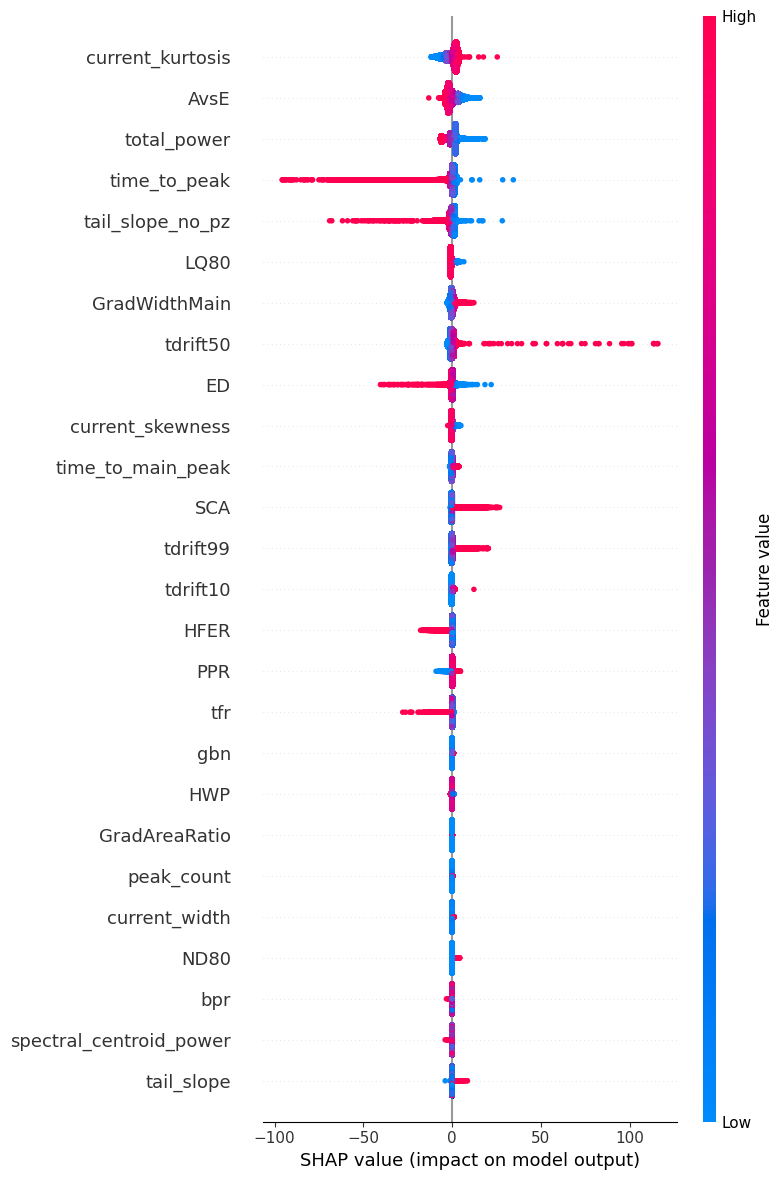

In [21]:
# Extract steps before the final model (standard scaler, imputer)
preprocessor = pipe_baseline[:-1] # All steps before the final model

# Transform the data manually
# model needs scaled/imputed data to calculate SHAP values correctly
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Create the Linear Explainer
# give it the model and the background dataset (X_train_processed)
lr_model = pipe_baseline.named_steps['lr']
explainer = shap.LinearExplainer(lr_model, X_train_processed, feature_perturbation="interventional")

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_processed)

# Plot
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, max_display=len(feature_cols))

### Optimizing Logistic Regression (hyperparamter tunning)

In [76]:
# tune the 'lr' (Logistic Regression) part of the pipe
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__class_weight': [
        'balanced',
        {0:2, 1:1},
        {0:1, 1:3},
        {0:1, 1:5},   # Mild imbalance
        {0:1, 1:10},  # Moderate
        None          # Baseline (equal weight)
    ]
}

# Use Standard Stratified K-Fold for speed during the search
lr_grid = GridSearchCV(
    estimator=pipe_baseline,        
    param_grid=lr_param_grid, 
    cv=StratifiedKFold(n_splits=5), 
    scoring=scoring_metrics,
    refit='MCC',
    n_jobs=-1,
    verbose=1
)

print("Tuning hyperparameters for Logistic Regression...")
lr_grid.fit(X_train, y_train) # runs the internal CV loops

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=2000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lr__C': [0.01, 0.1, ...], 'lr__class_weight': ['balanced', {0: 2, 1: 1}, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'AUC_PR': make_scorer(a...redict_proba'), 'AUC_ROC': make_scorer(r...redict_proba'), 'Class0_F1': make_scorer(f..., pos_label=0), 'Class1_F1': make_scorer(f..., pos_label=1), ...}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'MCC'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold

In [77]:
# RESULTS VISUALIZATION
# Get the best model
lr_best_model = lr_grid.best_estimator_
print(f"Best Params found: {lr_grid.best_params_}")

# Convert the results dictionary to a DataFrame
cv_results_lr = lr_grid.cv_results_
results_df_lr = pd.DataFrame(cv_results_lr)

# Show full param dict
pd.set_option('display.max_colwidth', None)

# sorted by best performance
clean_results = results_df_lr.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]
clean_results

Best Params found: {'lr__C': 1, 'lr__class_weight': {0: 2, 1: 1}}


,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
13,"{'lr__C': 1, 'lr__class_weight': {0: 2, 1: 1}}",0.391295,0.999306,0.944328,0.364213,0.996251,444.6,1243.6,206004.8,307.0
19,"{'lr__C': 10, 'lr__class_weight': {0: 2, 1: 1}}",0.391283,0.999307,0.944380,0.364004,0.996253,444.0,1244.2,206006.2,305.6
25,"{'lr__C': 100, 'lr__class_weight': {0: 2, 1: 1}}",0.390539,0.999307,0.944491,0.363524,0.996246,443.8,1244.4,206003.8,308.0
7,"{'lr__C': 0.1, 'lr__class_weight': {0: 2, 1: 1}}",0.390529,0.999308,0.944611,0.362820,0.996254,441.6,1246.6,206009.0,302.8
1,"{'lr__C': 0.01, 'lr__class_weight': {0: 2, 1: 1}}",0.389321,0.999308,0.944244,0.359118,0.996272,432.4,1255.8,206025.6,286.2
29,"{'lr__C': 100, 'lr__class_weight': None}",0.356338,0.999198,0.937914,0.296419,0.996329,320.2,1368.0,206160.6,151.2
23,"{'lr__C': 10, 'lr__class_weight': None}",0.355568,0.999203,0.938068,0.295939,0.996325,319.8,1368.4,206159.4,152.4
11,"{'lr__C': 0.1, 'lr__class_weight': None}",0.354825,0.999205,0.937690,0.294521,0.996326,317.6,1370.6,206161.8,150.0
17,"{'lr__C': 1, 'lr__class_weight': None}",0.354821,0.999202,0.938023,0.295142,0.996323,318.8,1369.4,206159.4,152.4
5,"{'lr__C': 0.01, 'lr__class_weight': None}",0.353918,0.999202,0.936209,0.290545,0.996335,310.8,1377.4,206172.6,139.2


In [78]:
df_lr_tuning = tune_thresholds(
    lr_best_model, 
    X_train, 
    y_train
)

print(">>> Logistic Regression Threshold Tuning <<<")
display(df_lr_tuning)

>>> Logistic Regression Threshold Tuning <<<


,Threshold,MCC,Precision,Recall,Class1_F1,Class0_F1,TN,FP,FN,TP,AUC_PR,AUC_ROC
7,0.80,0.428814,0.995543,0.994692,0.995117,0.433148,3847,4594,5475,1026084,0.999312,0.945059
6,0.70,0.422115,0.994815,0.996982,0.995898,0.421045,3081,5360,3113,1028446,0.999312,0.945059
5,0.60,0.405243,0.994317,0.997984,0.996147,0.391038,2557,5884,2080,1029479,0.999312,0.945059
8,0.90,0.393066,0.996711,0.986389,0.991523,0.368801,5083,3358,14041,1017518,0.999312,0.945059
4,0.50,0.391366,0.993999,0.998508,0.996249,0.364337,2223,6218,1539,1030020,0.999312,0.945059
3,0.40,0.386170,0.993803,0.998870,0.996330,0.346898,2016,6425,1166,1030393,0.999312,0.945059
2,0.30,0.374166,0.993613,0.999093,0.996345,0.324489,1816,6625,936,1030623,0.999312,0.945059
1,0.20,0.360743,0.993440,0.999259,0.996341,0.301504,1634,6807,764,1030795,0.999312,0.945059
0,0.10,0.341205,0.993236,0.999414,0.996315,0.271355,1420,7021,605,1030954,0.999312,0.945059
9,0.95,0.321380,0.997694,0.966616,0.981909,0.250372,6136,2305,34438,997121,0.999312,0.945059


In [79]:
best_row_lr = df_lr_tuning.loc[df_lr_tuning['MCC'].idxmax()]
best_threshold_lr = best_row_lr['Threshold']

print(f"Best Params: {lr_grid.best_params_}")
print(f"Best Threshold: {best_threshold_lr}")
print(f"Best MCC:       {best_row_lr['MCC']:.4f}")

Best Params: {'lr__C': 1, 'lr__class_weight': {0: 2, 1: 1}}
Best Threshold: 0.8
Best MCC:       0.4288



 EVALUATION: Optimized Logistic Regression (Threshold = 0.8)
              precision    recall  f1-score   support

       False       0.41      0.45      0.43      3160
        True       1.00      0.99      1.00    386840

    accuracy                           0.99    390000
   macro avg       0.70      0.72      0.71    390000
weighted avg       0.99      0.99      0.99    390000

AUC-ROC Score: 0.9429791672938408
AUC-PR Score:  0.9992913168610752
MCC Score:     0.4251533261673993


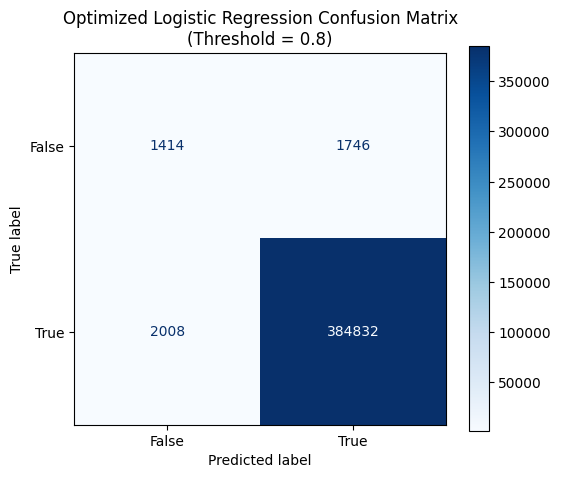

In [80]:
evaluate_model_with_threshold(
    lr_best_model, 
    X_test, 
    y_test, 
    best_threshold_lr, 
    model_name="Optimized Logistic Regression")

In [81]:
# Extract the Logistic Regression step and its coefficients
coef_lr = lr_best_model.named_steps['lr'].coef_[0]

feat_imp_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coef_lr,
    'Abs_Importance': abs(coef_lr)
})

# Sort by Absolute Importance (biggest impact at the top)
feat_imp_lr = feat_imp_lr.sort_values(by='Abs_Importance', ascending=False)

# Use an option context to force Pandas to print the WHOLE list, not just top/bottom
print(f"\n--- FULL FEATURE RANKING: Impact of All {len(feat_imp_lr)} Features on High AVSE ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feat_imp_lr[['Feature', 'Coefficient']])


--- FULL FEATURE RANKING: Impact of All 26 Features on High AVSE ---
                    Feature  Coefficient
11              total_power    -2.891433
24            GradWidthMain     1.512911
22                     AvsE    -1.452483
9          current_kurtosis     1.296411
7          tail_slope_no_pz    -1.232985
2                      LQ80    -1.043862
13             time_to_peak    -0.758714
4                       SCA     0.642839
16                 tdrift50     0.561649
25                     HFER    -0.402202
15                 tdrift10     0.368226
3                       PPR     0.321288
6          current_skewness    -0.215581
10               tail_slope     0.195965
18                      tfr    -0.168915
19               peak_count     0.135719
5                      ND80     0.133706
23            GradAreaRatio    -0.093251
0                        ED    -0.069951
20                      gbn     0.065343
17                 tdrift99    -0.062166
14            current_width 

### XGBoost

In [31]:
# ==========================================
# 1. SETUP & IMBALANCE HANDLING
# ==========================================
# Calculate Ratio: (Count of 0) / (Count of 1)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Baseline Imbalance Ratio (Neg/Pos): {ratio:.5f}")

# The Parameter Grid
# ==========================================
# 1. SETUP & IMBALANCE HANDLING
# ==========================================
# Calculate Ratio: (Count of 0) / (Count of 1)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# The Parameter Grid (includes Defaults)
param_grid_xgb = {
    'scale_pos_weight': [1, ratio, ratio * 0.5, ratio * 2, 0.05, 0.1, 0.5], 
    'max_depth': [3, 4, 5, 6],            
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],   
    'n_estimators': [100, 200, 500, 1000],     
    'gamma': [0, 0.1, 1.0],                      
    'colsample_bytree': [0.7, 0.9, 1.0],
    'subsample': [0.6, 0.8, 1.0],
}

# The Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

Baseline Imbalance Ratio (Neg/Pos): 0.00818


In [32]:
# ==========================================
# 2. HYPERPARAMETER TUNING (The Search)
# ==========================================
search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_xgb,
    n_iter=20,
    scoring=scoring_metrics,  
    refit='MCC',          
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting Hyperparameter Tuning...")
search_xgb.fit(X_train, y_train)

# Get the winner
best_xgb = search_xgb.best_estimator_

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [33]:
# 1. Convert the raw results dictionary to a DataFrame
results = pd.DataFrame(search_xgb.cv_results_)

# 3. Sort, Filter, and Store in a new DataFrame variable
top_models_df = results.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]

# 4. Display the stored DataFrame
top_models_df

,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
3,"{'subsample': 1.0, 'scale_pos_weight': 0.5, 'n...",0.679126,0.999960,0.995558,0.681069,0.997491,1105.4,582.8,205859.2,452.6
11,"{'subsample': 0.8, 'scale_pos_weight': 0.1, 'n...",0.620851,0.999952,0.994513,0.594374,0.995187,1449.8,238.4,204571.4,1740.4
13,"{'subsample': 1.0, 'scale_pos_weight': 0.1, 'n...",0.619071,0.999951,0.994433,0.592988,0.995180,1443.4,244.8,204575.0,1736.8
1,"{'subsample': 1.0, 'scale_pos_weight': 0.5, 'n...",0.617453,0.999929,0.991951,0.620257,0.996972,1020.8,667.4,205729.4,582.4
15,"{'subsample': 1.0, 'scale_pos_weight': 1, 'n_e...",0.613367,0.999672,0.981634,0.611142,0.997179,916.6,771.6,205918.2,393.6
14,"{'subsample': 1.0, 'scale_pos_weight': 1, 'n_e...",0.587278,0.999146,0.949702,0.587230,0.996936,900.4,787.8,205834.2,477.6
16,"{'subsample': 1.0, 'scale_pos_weight': 1, 'n_e...",0.566258,0.999852,0.989551,0.556000,0.997008,774.2,914.0,205989.4,322.4
5,"{'subsample': 0.6, 'scale_pos_weight': 0.1, 'n...",0.545150,0.999807,0.980829,0.529435,0.994712,1223.6,464.6,204601.2,1710.6
7,"{'subsample': 0.8, 'scale_pos_weight': 1, 'n_e...",0.544564,0.999909,0.989777,0.532958,0.996893,732.6,955.6,205983.4,328.4
8,"{'subsample': 0.8, 'scale_pos_weight': 0.00409...",0.542256,0.999963,0.995688,0.470912,0.991086,1622.8,65.4,202730.6,3581.2


In [34]:
df_xgb_tuning = tune_thresholds(
    best_xgb, 
    X_train, 
    y_train
)

print(">>> XGBoost Threshold Tuning <<<")
display(df_xgb_tuning)

Generating Cross-Validated Probabilities (CV=5)...
>>> XGBoost Threshold Tuning <<<


,Threshold,MCC,Precision,Recall,True_F1,False_F1,TN,FP,FN,TP,CV_AUC_PR,CV_AUC_ROC
6,0.70,0.688516,0.998030,0.996335,0.997181,0.688204,6412,2029,3781,1027778,0.999956,0.995371
5,0.60,0.686714,0.997606,0.997167,0.997387,0.689086,5973,2468,2922,1028637,0.999956,0.995371
7,0.80,0.682922,0.998457,0.995173,0.996813,0.676202,6855,1586,4979,1026580,0.999956,0.995371
4,0.50,0.676988,0.997170,0.997772,0.997471,0.679009,5520,2921,2298,1029261,0.999956,0.995371
8,0.90,0.658889,0.998987,0.992829,0.995898,0.637005,7402,1039,7397,1024162,0.999956,0.995371
3,0.40,0.658489,0.996666,0.998281,0.997473,0.656936,4996,3445,1773,1029786,0.999956,0.995371
2,0.30,0.630951,0.996093,0.998722,0.997406,0.621513,4400,4041,1318,1030241,0.999956,0.995371
9,0.95,0.621543,0.999312,0.989925,0.994596,0.582418,7738,703,10393,1021166,0.999956,0.995371
1,0.20,0.590232,0.995367,0.999190,0.997274,0.563932,3643,4798,836,1030723,0.999956,0.995371
10,0.99,0.510931,0.999717,0.979304,0.989405,0.429833,8155,286,21349,1010210,0.999956,0.995371


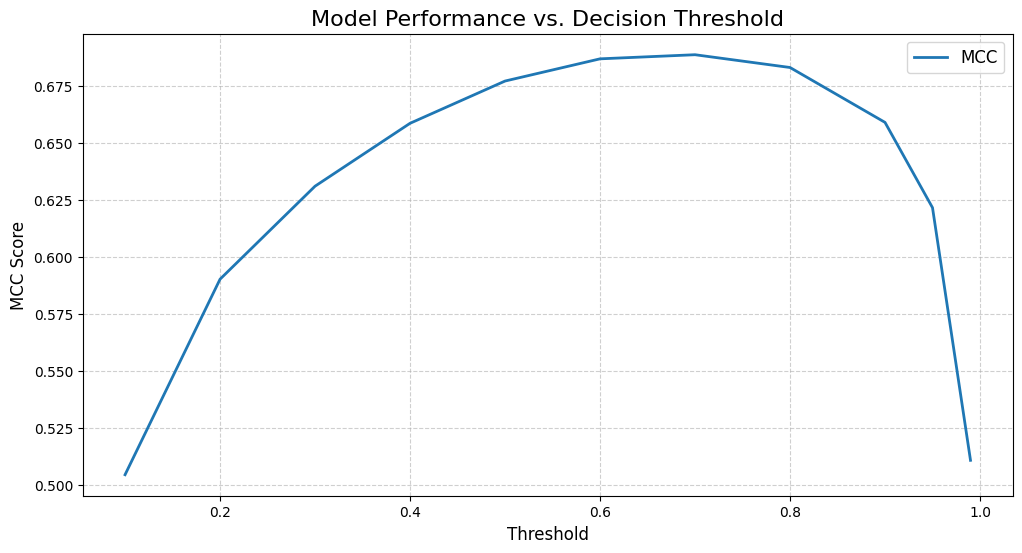

In [40]:
df = df_xgb_tuning.sort_values(by='Threshold')

plt.figure(figsize=(12, 6))
plt.plot(df['Threshold'], df["MCC"], label="MCC", linewidth=2)
plt.title('Model Performance vs. Decision Threshold', fontsize=16)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('MCC Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

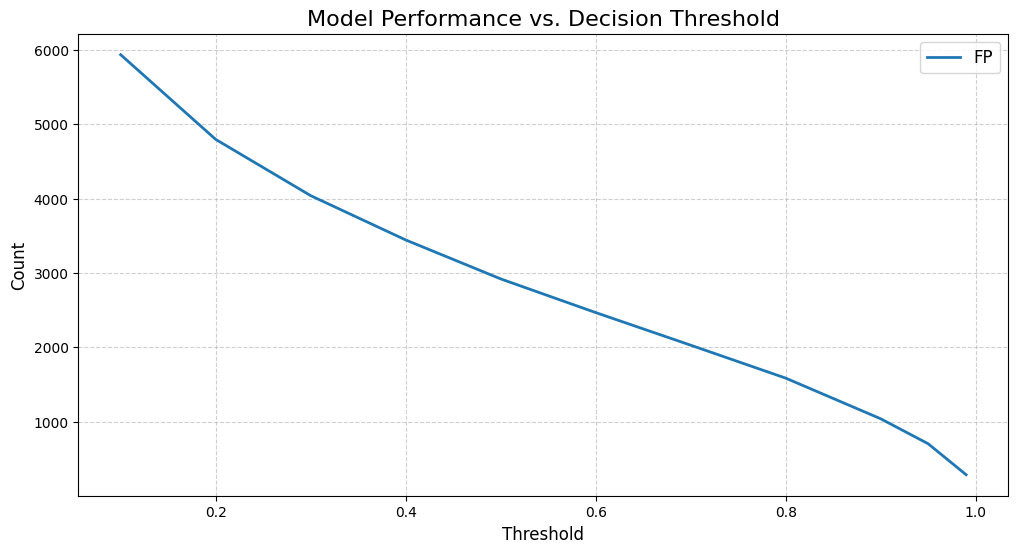

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(df['Threshold'], df["FP"], label="FP", linewidth=2)
plt.title('Model Performance vs. Decision Threshold', fontsize=16)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [35]:
# ==========================================
# 5. FINAL REPORT (Production Ready)
# ==========================================
# Automatically select best threshold based on MCC
best_row_xgb = df_xgb_tuning.loc[df_xgb_tuning['MCC'].idxmax()]
best_threshold_xgb = best_row_xgb['Threshold']

print(f"Best Params: {search_xgb.best_params_}")
print(f"Best Threshold: {best_threshold_xgb}")
print(f"Best MCC:       {best_row_xgb['MCC']:.4f}")

Best Params: {'subsample': 1.0, 'scale_pos_weight': 0.5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Threshold: 0.7
Best MCC:       0.6885



 EVALUATION: XGBoost (Threshold = 0.7)
              precision    recall  f1-score   support

       False       0.64      0.78      0.70      3160
        True       1.00      1.00      1.00    386840

    accuracy                           0.99    390000
   macro avg       0.82      0.89      0.85    390000
weighted avg       1.00      0.99      0.99    390000

AUC-ROC Score: 0.996270217775576
AUC-PR Score:  0.9999686541795105
MCC Score:     0.7002017587589946


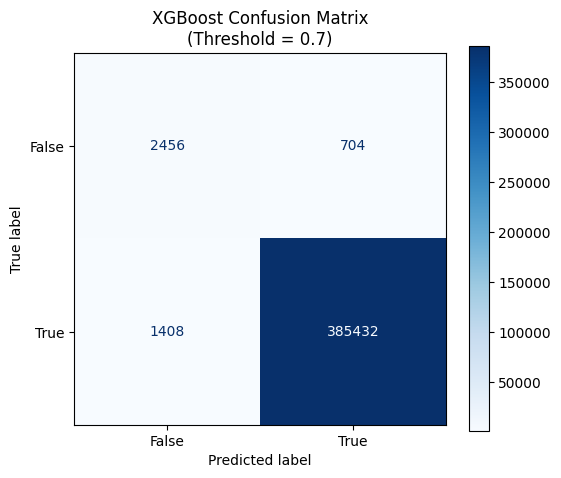

In [36]:
evaluate_model_with_threshold(
    best_xgb, 
    X_test, 
    y_test, 
    best_threshold_xgb, 
    model_name="XGBoost")


>>> XGBOOST FEATURE IMPORTANCE RANKING <<<
              Feature  Importance
0            tdrift99    0.212198
1        time_to_peak    0.181557
2            tdrift50    0.113049
3                 tfr    0.099120
4   time_to_main_peak    0.064717
5                 bpr    0.028109
6                 PPR    0.025030
7       GradWidthMain    0.022216
8    tail_slope_no_pz    0.021966
9    current_skewness    0.020068
10                 ED    0.019952
11                HWP    0.019013
12      current_width    0.016831
13   current_kurtosis    0.016122
14               AvsE    0.016037


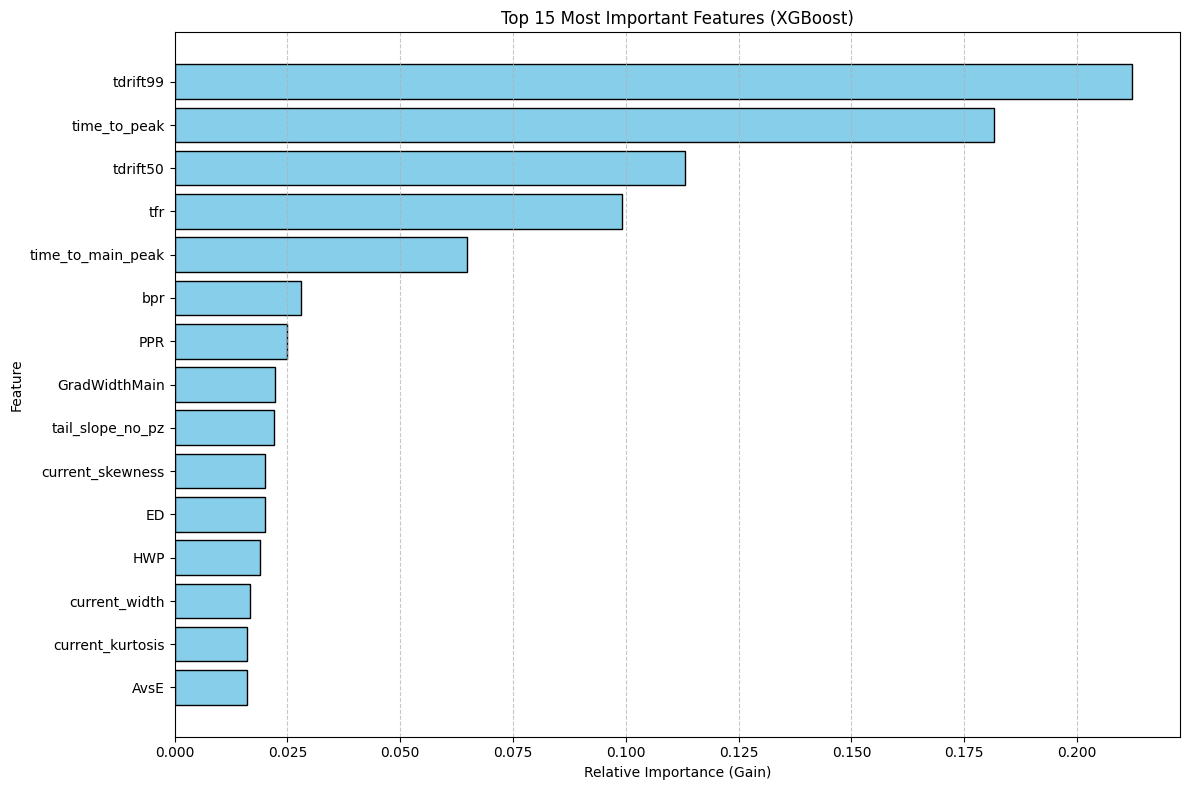

In [32]:
# ==========================================
# 1. EXTRACT IMPORTANCE (XGBoost)
# ==========================================
# Get the feature names (assuming X_train is a DataFrame)
feature_names_xgb = X_train.columns

# Get the raw importance scores (Gain/Gini)
importances_xgb = best_xgb.feature_importances_

# Create a DataFrame for easy viewing
feature_df_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': importances_xgb
})

# Sort by importance (Highest on top)
feature_df_xgb = feature_df_xgb.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the ranking as a table
print("\n>>> XGBOOST FEATURE IMPORTANCE RANKING <<<")
print(feature_df_xgb.head(15)) 

# ==========================================
# 2. VISUALIZE (Bar Chart)
# ==========================================
top_n = 15  # <--- ADJUST THIS to show more/less features
plot_data_xgb = feature_df_xgb.head(top_n)

plt.figure(figsize=(12, 8))

# Create Bar Plot
plt.barh(plot_data_xgb['Feature'], plot_data_xgb['Importance'], color='skyblue', edgecolor='black')

plt.xlabel('Relative Importance (Gain)')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Most Important Features (XGBoost)')
plt.gca().invert_yaxis() # Invert so the #1 feature is at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Random Forest

In [48]:
# ==========================================
# 1. SETUP & GRID
# ==========================================
# Random Forest Grid
param_grid_rf = {
    'n_estimators': [100, 200],        
    'max_depth': [5, 10, 15, None],          
    'min_samples_leaf': [1, 2, 4],           
    'min_samples_split': [2, 5, 10],         
    'max_features': ['sqrt', 'log2'],
    'class_weight': [
        None,                    # Baseline: treat them as they appear
        'balanced_subsample',
        'balanced',             # Standard: helps catch the minority (but increases FPs)
        {0:1, 1:2},          # Strong majority bias (significant FP reduction
        {0:1, 1:5},            # Mild imbalance
        {0:2, 1:1}           # Slight minority bias (if 'balanced' is too much)
    ]
}

rf_clf = RandomForestClassifier(
    random_state=42, 
    n_jobs=1
)

# ==========================================
# 2. HYPERPARAMETER TUNING
# ==========================================
search_rf = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid_rf,
    n_iter=15,
    scoring=scoring_metrics,  
    refit='MCC',          
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=6,
    random_state=42
)

print("Starting Hyperparameter Tuning for Random Forest...")
search_rf.fit(X_train, y_train)

best_rf = search_rf.best_estimator_

Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [50]:
results_rf = pd.DataFrame(search_rf.cv_results_)

rf_models_results = results_rf.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]
rf_models_results

,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
11,"{'n_estimators': 100, 'min_samples_split': 10,...",0.564624,0.999831,0.981920,0.556832,0.996962,1314.333333,1499.333333,343260.333333,592.666667
10,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.534193,0.999933,0.992345,0.482831,0.992309,2452.333333,361.333333,338960.333333,4892.666667
1,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.479264,0.999645,0.964375,0.468430,0.996496,1063.333333,1750.333333,343190.000000,663.000000
8,"{'n_estimators': 200, 'min_samples_split': 10,...",0.454426,0.999813,0.980014,0.388201,0.996729,715.666667,2098.000000,343695.333333,157.666667
14,"{'n_estimators': 100, 'min_samples_split': 10,...",0.441174,0.999895,0.988506,0.359801,0.996702,639.333333,2174.333333,343752.333333,100.666667
0,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.417824,0.999902,0.988895,0.323361,0.983914,2602.666667,211.000000,333170.000000,10683.000000
4,"{'n_estimators': 200, 'min_samples_split': 10,...",0.377498,0.999575,0.959201,0.317564,0.996405,577.000000,2236.666667,343610.000000,243.000000
9,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.336076,0.999790,0.977982,0.226728,0.996379,366.666667,2447.000000,343801.000000,52.000000
12,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.327737,0.999786,0.977230,0.219954,0.996354,355.000000,2458.666667,343795.666667,57.333333
2,"{'n_estimators': 200, 'min_samples_split': 10,...",0.312506,0.999794,0.977878,0.199731,0.996317,317.333333,2496.333333,343807.666667,45.333333


In [65]:
df_rf_tuning = tune_thresholds(
    best_rf, 
    X_train, 
    y_train
)

print(">>> Random Forest Threshold Tuning <<<")
display(df_rf_tuning)

>>> Random Forest Threshold Tuning <<<


,Threshold,MCC,Precision,Recall,Class1_F1,Class0_F1,TN,FP,FN,TP,AUC_PR,AUC_ROC
5,0.60,0.643860,0.996890,0.997555,0.997223,0.646042,5231,3210,2522,1029037,0.99986,0.984829
4,0.50,0.638386,0.996245,0.998608,0.997425,0.631521,4558,3883,1436,1030123,0.99986,0.984829
6,0.70,0.636410,0.997456,0.996132,0.996793,0.637773,5820,2621,3990,1027569,0.99986,0.984829
7,0.80,0.614146,0.998050,0.993773,0.995907,0.604422,6438,2003,6424,1025135,0.99986,0.984829
3,0.40,0.606037,0.995477,0.999258,0.997364,0.579759,3758,4683,765,1030794,0.99986,0.984829
2,0.30,0.542433,0.994536,0.999705,0.997114,0.481771,2775,5666,304,1031255,0.99986,0.984829
8,0.90,0.534411,0.998671,0.987065,0.992834,0.490890,7086,1355,13343,1018216,0.99986,0.984829
9,0.95,0.433600,0.999107,0.973717,0.986249,0.350056,7543,898,27112,1004447,0.99986,0.984829
1,0.20,0.412153,0.993302,0.999959,0.996619,0.297953,1485,6956,42,1031517,0.99986,0.984829
10,0.99,0.230767,0.999627,0.884141,0.938344,0.119082,8101,340,119515,912044,0.99986,0.984829


In [66]:
best_row_rf = df_rf_tuning.loc[df_rf_tuning['MCC'].idxmax()]
best_threshold_rf = best_row_rf['Threshold']

print(f"Best Params: {search_rf.best_params_}")
print(f"Best Threshold: {best_threshold_rf}")
print(f"Best MCC: {best_row_rf['MCC']:.4f}")

Best Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'class_weight': {0: 2, 1: 1}}
Best Threshold: 0.6
Best MCC: 0.6439



 EVALUATION: Random Forest (Threshold = 0.6)
              precision    recall  f1-score   support

       False       0.60      0.55      0.57      3160
        True       1.00      1.00      1.00    386840

    accuracy                           0.99    390000
   macro avg       0.80      0.77      0.78    390000
weighted avg       0.99      0.99      0.99    390000

AUC-ROC Score: 0.981789308928298
AUC-PR Score:  0.999829322836687
MCC Score:     0.5666025816869594


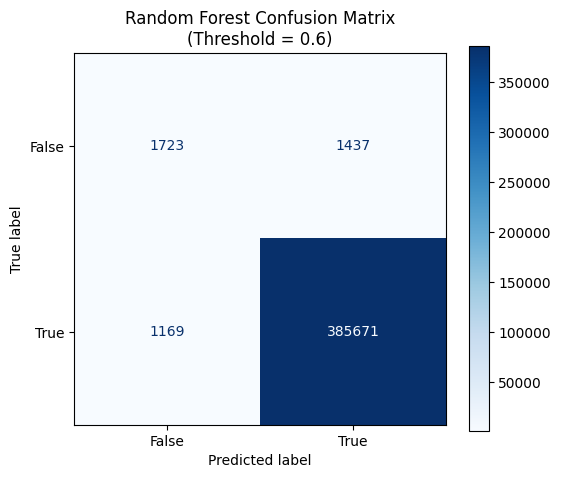

In [67]:
evaluate_model_with_threshold(
    best_rf, 
    X_test, 
    y_test, 
    best_threshold_rf, 
    model_name="Random Forest")

### Balanced Random Forest

In [38]:
# ==========================================
# 2. SETUP MODEL & GRID
# ==========================================
# Balanced Random Forest automatically undersamples majority class per tree
brf_model = BalancedRandomForestClassifier(
    n_jobs=1,
    random_state=42,
    replacement=True,         # Crucial for undersampling
    sampling_strategy="all"   # 1:1 ratio in every tree
)

param_grid_brf = {
    'n_estimators': [500, 1000],          # High tree count
    'max_depth': [10, 20, None],          # Depth control
    'min_samples_leaf': [1, 2, 4],        # Overfitting control
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None]                # BRF handles balancing internally
}

# ==========================================
# 3. HYPERPARAMETER TUNING
# ==========================================
search_brf = RandomizedSearchCV(
    estimator=brf_model,
    param_distributions=param_grid_brf,
    n_iter=15,
    scoring=scoring_metrics,  # <--- Your custom list
    refit='MCC',              # <--- Optimize for MCC
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=4,
    random_state=42
)

print("Starting Balanced Random Forest Tuning...")
search_brf.fit(X_train, y_train)

Starting Balanced Random Forest Tuning...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",BalancedRando...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'class_weight': [None], 'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.","{'AUC_PR': make_scorer(a...redict_proba'), 'AUC_ROC': make_scorer(r...redict_proba'), 'Class0_F1': make_scorer(f..., pos_label=0), 'Class1_F1': make_scorer(f..., pos_label=1), ...}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",4
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'MCC'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are i

In [40]:
# 1. Convert the raw results dictionary to a DataFrame
results = pd.DataFrame(search_brf.cv_results_)

# 3. Sort, Filter, and Store in a new DataFrame variable
#    We sort by MCC because that was your refit metric
top_models_df = results.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]

# Display the top 5
top_models_df

,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
1,"{'n_estimators': 1000, 'min_samples_leaf': 1, ...",0.422622,0.999939,0.992854,0.321325,0.983128,2701.666667,112.000000,332550.666667,11302.333333
7,"{'n_estimators': 500, 'min_samples_leaf': 1, '...",0.422586,0.999938,0.992805,0.321178,0.983107,2703.000000,110.666667,332535.333333,11317.666667
5,"{'n_estimators': 1000, 'min_samples_leaf': 1, ...",0.421766,0.999937,0.992752,0.320289,0.983045,2701.666667,112.000000,332496.000000,11357.000000
3,"{'n_estimators': 500, 'min_samples_leaf': 1, '...",0.421635,0.999936,0.992710,0.320131,0.983032,2701.666667,112.000000,332487.333333,11365.666667
2,"{'n_estimators': 500, 'min_samples_leaf': 2, '...",0.416504,0.999936,0.992582,0.313702,0.982494,2704.666667,109.000000,332126.333333,11726.666667
6,"{'n_estimators': 1000, 'min_samples_leaf': 2, ...",0.414100,0.999935,0.992482,0.311072,0.982295,2701.333333,112.333333,331997.333333,11855.666667
14,"{'n_estimators': 1000, 'min_samples_leaf': 4, ...",0.403477,0.999932,0.992139,0.297787,0.981074,2709.000000,104.666667,331180.000000,12673.000000
9,"{'n_estimators': 1000, 'min_samples_leaf': 4, ...",0.403383,0.999932,0.992130,0.297675,0.981064,2709.000000,104.666667,331173.333333,12679.666667
4,"{'n_estimators': 500, 'min_samples_leaf': 4, '...",0.403024,0.999932,0.992105,0.297348,0.981043,2707.666667,106.000000,331161.000000,12692.000000
0,"{'n_estimators': 1000, 'min_samples_leaf': 4, ...",0.400493,0.999930,0.991951,0.294475,0.980785,2706.000000,107.666667,330991.333333,12861.666667


In [59]:
best_brf = search_brf.best_estimator_

df_brf_tuning = tune_thresholds(
    best_brf, 
    X_train, 
    y_train
)

print(">>> Balanced Random Forest Threshold Tuning <<<")
display(df_brf_tuning)

>>> Balanced Random Forest Threshold Tuning <<<


,Threshold,MCC,Precision,Recall,Class1_F1,Class0_F1,TN,FP,FN,TP,AUC_PR,AUC_ROC
0,0.10,0.711953,0.999165,0.994420,0.996787,0.696387,7584,857,5756,1025803,0.999986,0.998237
1,0.20,0.638537,0.999750,0.989280,0.994488,0.591367,8186,255,11058,1020501,0.999986,0.998237
2,0.30,0.569078,0.999935,0.983660,0.991731,0.497446,8375,66,16856,1014703,0.999986,0.998237
3,0.40,0.506138,0.999993,0.977021,0.988374,0.415683,8434,7,23704,1007855,0.999986,0.998237
4,0.50,0.449953,1.000000,0.969018,0.984265,0.345645,8441,0,31960,999599,0.999986,0.998237
5,0.60,0.398755,1.000000,0.958839,0.978987,0.284487,8441,0,42460,989099,0.999986,0.998237
6,0.70,0.347843,1.000000,0.944319,0.971362,0.227153,8441,0,57438,974121,0.999986,0.998237
7,0.80,0.292191,1.000000,0.920006,0.958336,0.169837,8441,0,82519,949040,0.999986,0.998237
8,0.90,0.223930,1.000000,0.866744,0.928616,0.109380,8441,0,137461,894098,0.999986,0.998237
9,0.95,0.177110,1.000000,0.799598,0.888640,0.075498,8441,0,206727,824832,0.999986,0.998237


In [61]:
best_row_brf = df_brf_tuning.loc[df_brf_tuning['MCC'].idxmax()]
best_threshold_brf = best_row_brf['Threshold']

print(f"Best Params: {search_brf.best_params_}")
print(f"Best Threshold: {best_threshold_brf}")
print(f"Best MCC: {best_row_brf['MCC']:.4f}")

Best Params: {'n_estimators': 1000, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': None}
Best Threshold: 0.1
Best MCC: 0.7120



 EVALUATION: Balanced Random Forest (Threshold = 0.1)
              precision    recall  f1-score   support

       False       0.49      0.73      0.59      3160
        True       1.00      0.99      1.00    386840

    accuracy                           0.99    390000
   macro avg       0.75      0.86      0.79    390000
weighted avg       0.99      0.99      0.99    390000

AUC-ROC Score: 0.9936591580563843
AUC-PR Score:  0.9999444934299945
MCC Score:     0.5972998128225394


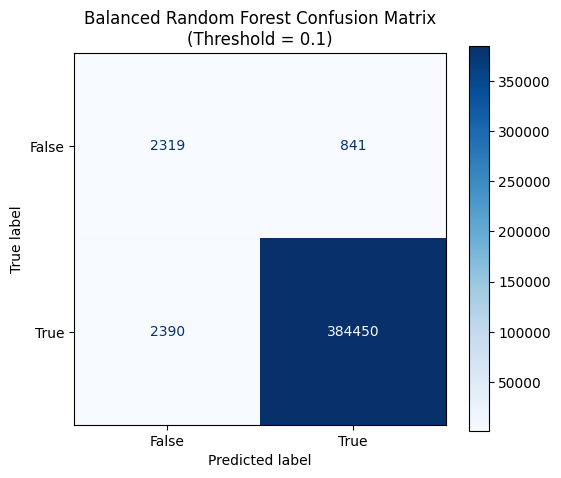

In [64]:
evaluate_model_with_threshold(
    best_brf, 
    X_test, 
    y_test, 
    best_threshold_brf, 
    model_name="Balanced Random Forest")